# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 43.9 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.5/821.5 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


## Importing dependencies and define helper functions

In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
import pygame
import os
import time
from IPython.display import HTML
from IPython import display as ipythondisplay

from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Tutorial: Loading CartPole environment

In [ ]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [ ]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [ ]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [ ]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.04286911  0.00080168 -0.04145709 -0.02947812]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [ ]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.04285308 -0.19370198 -0.04204666  0.24984181]
Reward for this step: 1.0
Is this round done? False


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [ ]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


In [ ]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [ ]:
os.environ['SDL_VIDEODRIVER']='dummy'
pygame.display.set_mode((640,480))

<Surface(640x480x32 SW)>

#Task 1: Development of an RL agent

Development of an RL agent. Demonstrate the correctness of the implementation by sampling a random state from the cart pole environment, inputting to the agent, and outputting a chosen action. Print the values of the state and chosen action in Jupyter notebook.

## 1. Q-Learning (Learning Rate: 0.01)

> **Step 1: Define `get_discrete_state`** converts the continuous state space into a discrete one for Q-table indexing.
  
> It takes in:
> 1. Cart Position
> 2. Cart Velocity
> 3. Pole Angle
> 4. Pole Angular Velocity


In [ ]:
def get_discrete_state(state):
    discrete_state = state/np_array_win_size+ np.array([15,10,1,10])
    return tuple(discrete_state.astype(int))


> **Step 2: `q_policy_agent`** selects an action based on epsilon-greedy policy, where with probability epsilon, a random action is chosen, and with probability (1 - epsilon), the action with the highest Q-value is chosen.



In [ ]:
def q_policy_agent(q_table,discrete_state,env,epsilon):
  if np.random.random() > epsilon:
    return np.argmax(q_table[discrete_state])
  else:
    return np.random.randint(0, env.action_space.n)

>**Step 3: Training Q-Learning Model with 200,000 Episodes.**    
We implemented Q-learning with epsilon-greedy policy for solving the Cartpole problem.

> **1)** Initialise Learning Rate to 0.1, Discount Factor(gamma) to 0.95, Epsilon to 1, Epsilonn Decay Value to 0.99995 etc

>> LEARNINGRATE = 0.1

>> DISCOUNT = 0.95

>> epsilon = 1

>> epsilon_decay_value = 0.99995

>> lr_decay_value = 0.99995

>> EPISODES = 200000

>> observation = [30, 30, 50, 50]

>> np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1])



> **2)** Q-table is initialized with random values, where the shape is determined by the observation space dimensions and the number of actions.

>> q_table = np.random.uniform(low=0, high=1, size=(observation + [env.action_space.n]))


> **3)** It iteratively updates the Q-values based on the observed rewards and learns to balance the pole on the cart effectively over episodes.

> This is done through the use of Q-Learning Formula:

>> **new_q = (1 - LEARNINGRATE) * current_q + LEARNINGRATE* (reward + DISCOUNT * max_future_q)**







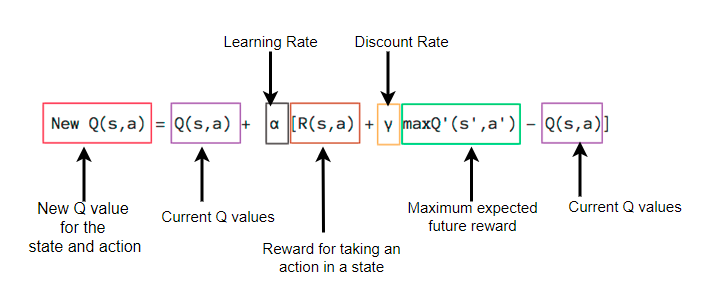

> Episode Execution:
>> *   During each episode, actions are selected based on the Q-policy until the episode terminates.

> Action Selection:
>> *   Actions are chosen either greedily based on the current Q-values or randomly with a decreasing probability controlled by epsilon.

> Environment Interaction:
>> *   The chosen action is executed in the environment, and the resulting new state and reward are observed.

> Q-value Update:
>> *   Q-values are updated based on the observed reward and the maximum future Q-value for the next state.

> Epsilon and Learning Rate Decay:
>> *   Epsilon and learning rate may decay over time, gradually reducing exploration and encouraging exploitation as training progresses





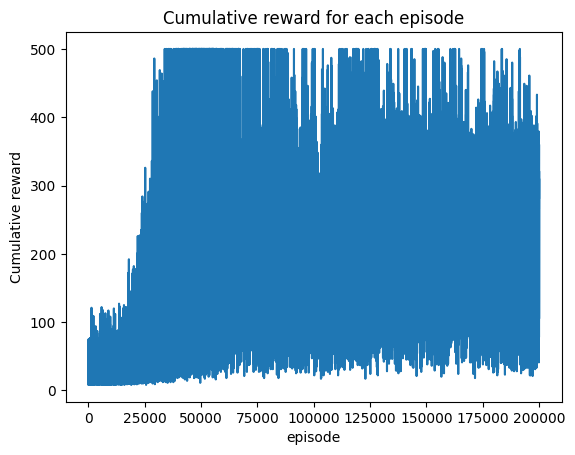

In [ ]:
LEARNINGRATE = 0.1
DISCOUNT = 0.95
EPISODES = 200000
total = 0
total_reward = 0
prior_reward = 0

observation = [30, 30, 50, 50]
np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1])

epsilon = 1
epsilon_decay_value = 0.99995
lr_decay_value = 0.99995

training_episode_results = np.zeros((EPISODES + 1,), dtype=int)

# Set up q-table
q_table = np.random.uniform(low=0, high=1, size=(observation + [env.action_space.n]))
q_table.shape


for episode in range(EPISODES + 1): #go through the episodes
    t0 = time.time() #set the initial time
    discrete_state = get_discrete_state(env.reset()) #get the discrete start for the restarted environment
    done = False
    episode_reward = 0 #reward starts as 0 for each episode

    while not done:

        if np.random.random() > epsilon:
            action = np.argmax(q_table[discrete_state]) #take cordinated action
        else:
            action = np.random.randint(0, env.action_space.n) #do a random action

        new_state, reward, done, _ = env.step(action) #step action to get new states, reward, and the "done" status.
        episode_reward += reward #add the reward
        new_discrete_state = get_discrete_state(new_state)

        if not done: #update q-table
            max_future_q = np.max(q_table[new_discrete_state])
            current_q = q_table[discrete_state + (action,)]
            new_q = (1 - LEARNINGRATE) * current_q + LEARNINGRATE * (reward + DISCOUNT * max_future_q)
            q_table[discrete_state + (action,)] = new_q

        discrete_state = new_discrete_state

    if epsilon > 0.05: #epsilon modification
        if episode_reward > prior_reward and episode > 10000:
            epsilon = math.pow(epsilon_decay_value, episode - 10000)
    training_episode_results[episode] = episode_reward


plt.plot(training_episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

In [ ]:
observation = env.reset()
action = q_policy_agent(q_table,discrete_state,env,epsilon)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [ 0.0362688  -0.04384357 -0.00219918 -0.03218657]
Chosen action: 0


## 2. Q-Learning (Learning Rate: 0.65)

> **Step 1: Define `get_discrete_state`**   
The function converts the continuous state environment into a discrete state represented by a tuple of integers.   
> It takes in:
> 1. Cart Position
> 2. Cart Velocity
> 3. Pole Angle
> 4. Pole Angular Velocity

In [ ]:
def get_discrete_state(state):
    discrete_state = state/np_array_win_size + np.array([15,10,1,10])
    return tuple(discrete_state.astype(int))

> **Step 2: Create the Q-Table**    
The Q-Table is used in Q-learning algorithm to store the estimated Q-values for each state-action pair in the environment. The Q-value represents the expected cumulative reward for taking a particular action from a particular state.

In [ ]:
# Define observation and window size
Observation = [40, 40, 50, 50]
np_array_win_size = np.array([0.25, 0.25, 0.05, 0.5])

In [ ]:
q_table = np.zeros((Observation + [env.action_space.n]))
q_table.shape

(40, 40, 50, 50, 2)

The Q-table is initialized with all zeroes to represent that the agent has no prior knowledge about the environment and its q-values. In the process of learning, the agent improves performance by updating the Q-values in response to rewards received and state transitions.

> **Step 3: Initializing the Hyperparameters**   


In [ ]:
LEARNING_RATE = 0.65
DISCOUNT = 1
EPISODES = 200000

epsilon = 1
epsilon_min = 0.05
epsilon_decay = (epsilon-epsilon_min)/12500

obs = env.reset()

In [ ]:
total = 0
total_reward = 0
prior_reward = 0

observation = [30, 30, 50, 50]
np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1])

epsilon = 1
epsilon_decay_value = 0.99995
lr_decay_value = 0.99995

training_episode_results_lr065 = np.zeros((EPISODES + 1,), dtype=int)

> **Step 4: Train the Q-Learning Model with 200,000 Episodes**


Episode: 0
Epsilon: 1
Mean Reward: 0.0
Episode: 5000
Epsilon: 1
Mean Reward: 22.4174
Episode: 10000
Epsilon: 1
Mean Reward: 22.2362
Episode: 15000
Epsilon: 0.7787959154194878
Mean Reward: 28.3054
Episode: 20000
Epsilon: 0.606523077874078
Mean Reward: 44.169
Episode: 25000
Epsilon: 0.47235769565598784
Mean Reward: 69.2502
Episode: 30000
Epsilon: 0.3678702439938449
Mean Reward: 100.1118
Episode: 35000
Epsilon: 0.28649584342677675
Mean Reward: 135.8692
Episode: 40000
Epsilon: 0.22312179264543486
Mean Reward: 180.1618
Episode: 45000
Epsilon: 0.17376634075333858
Mean Reward: 258.9872
Episode: 50000
Epsilon: 0.13532851641609098
Mean Reward: 328.8048
Episode: 55000
Epsilon: 0.10539329582463075
Mean Reward: 368.3468
Episode: 60000
Epsilon: 0.08207986830082019
Mean Reward: 419.8116
Episode: 65000
Epsilon: 0.06392346617084825
Mean Reward: 446.0012
Episode: 70000
Epsilon: 0.04999786897330457
Mean Reward: 446.5504
Episode: 75000
Epsilon: 0.04999786897330457
Mean Reward: 460.4212
Episode: 80000
Eps

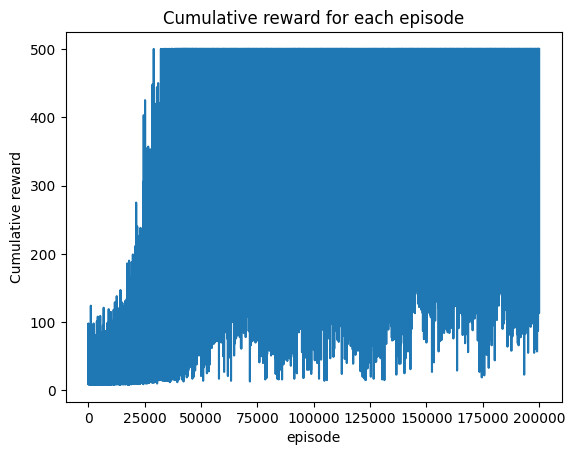

In [ ]:
total_reward_5000 = 0

for episode in range(EPISODES + 1): #go through the episodes
    t0 = time.time() #set the initial time
    discrete_state = get_discrete_state(env.reset()) #get the discrete start for the restarted environment
    done = False
    episode_reward = 0 #reward starts as 0 for each episode

    if episode % 5000 == 0:
            print("Episode: " + str(episode))

    while not done:
        if np.random.random() > epsilon:
            action = np.argmax(q_table[discrete_state]) #take cordinated action
        else:
            action = np.random.randint(0, env.action_space.n) #do a random action

        new_state, reward, done, _ = env.step(action) #step action to get new states, reward, and the "done" status.
        episode_reward += reward #add the reward
        new_discrete_state = get_discrete_state(new_state)

        if not done: #update q-table
            max_future_q = np.max(q_table[new_discrete_state])
            current_q = q_table[discrete_state + (action,)]
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            q_table[discrete_state + (action,)] = new_q

        discrete_state = new_discrete_state

    if epsilon > 0.05: #epsilon modification
        if episode_reward > prior_reward and episode > 10000:
            epsilon = math.pow(epsilon_decay_value, episode - 10000)

    if episode % 5000 == 0:
            print("Epsilon: " + str(epsilon))
            print("Mean Reward: " + str(total_reward_5000/5000))
            total_reward_5000 = 0 #reward start at 0 for every 5000 episodes

    training_episode_results_lr065[episode] = episode_reward
    total_reward_5000 += episode_reward


plt.plot(training_episode_results_lr065)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

In [ ]:
#Resetting the env and obtaining the initial observation
observation = env.reset()

#Printing out the first element of the observation array
print("Observation:" , observation)

#Converting the continuous observation to a discrete state
discrete_state = get_discrete_state(observation)

#Using the Q-table to choose the best action for the current state
action = np.argmax(q_table[discrete_state])

#Printing out the chosen action
print("Chosen Action:", action)

Observation: [-0.00702802  0.00350468  0.00016799  0.04385976]
Chosen Action: 1


## 3. DQN

### Agent

> **Introducing DQN**
>
>We use a DQN agent to solve this cartpole problem. The below image explains the entire process of the DQN model and the training.

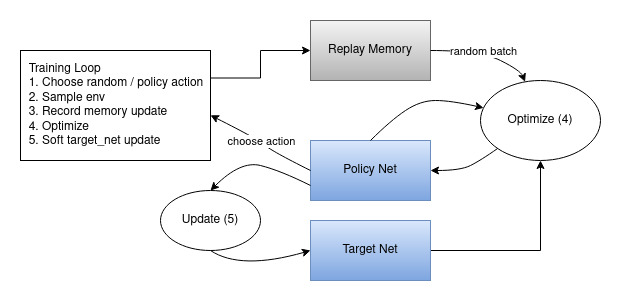

>**Setting up**
>
>Here we are setting up the environment for the CartPole-v1.  
>
>It enables interactive mode for matplotlib, allowing for dynamic plotting.
>
>It sets the device to CPU, which indicates that computations will be performed on the CPU rather than on a GPU.

In [3]:
# Create a CartPole environment
env = gym.make("CartPole-v1")

# Set up matplotlib
plt.ion()

# Set the device to CPU
device = torch.device("cpu")

>**Replay Memory**
>
>We define a `ReplayMemory` class, which is being used in this Deep Q-Network (DQN) reinforcement learning algorithm. Transitions represent state-action-reward-next_state tuples experienced by the agent during interactions with the environment.
>
>This implementation follows the typical structure of a replay memory used in deep reinforcement learning algorithms. It allows the agent to store and sample transitions, facilitating experience replay and improving sample efficiency during training.
>
>Each of the functions' usage is commented in the code below

In [4]:
# Creating a named tuple to represent a transition in the replay memory
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    """
    Replay Memory for storing and sampling transitions.

    Parameters:
        capacity (int): Maximum capacity of the replay memory.
    """

    def __init__(self, capacity):
        """Initialises the replay memory with a maximum capacity."""
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition in the replay memory."""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Sample a batch of transitions from the replay memory."""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Return the current size of the replay memory."""
        return len(self.memory)

>**DQN Class**
>
>The code below defines the DQN class.

In [5]:
class DQN(nn.Module):
    """
    Deep Q-Network (DQN) neural network model for approximating the Q-values of state-action pairs.

    Parameters:
        n_observations (int): Number of observations (features) in the input state.
        n_actions (int): Number of possible actions in the environment.

    Attributes:
        layer1 (nn.Linear): First fully connected layer with ReLU activation.
        layer2 (nn.Linear): Second fully connected layer with ReLU activation.
        layer3 (nn.Linear): Output layer representing Q-values for each action.
    """

    def __init__(self, n_observations, n_actions):
        """
        Initializes the DQN model architecture.

        Args:
            n_observations (int): Number of observations (features) in the input state.
            n_actions (int): Number of possible actions in the environment.
        """
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        """
        Forward pass of the DQN model.

        Args:
            x (torch.Tensor): Input tensor representing the state.

        Returns:
            torch.Tensor: Output tensor representing Q-values for each action.
        """
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

>**Setting up training | Defining functions**
>
>The following cells is the **Deep Q-Network (DQN) Training Setup**.
>
>They define the hyperparameters, initializes the neural networks, optimizer, and replay memory, and provides utility functions for the Deep Q-Network (DQN) training process.
>
>This setup prepares the environment and neural networks for training the DQN agent.


In [6]:
# Hyperparameters for the DQN algorithm
BATCH_SIZE = 128  # number of transitions sampled from the replay buffer
GAMMA = 0.99      # discount factor as mentioned in the previous section
EPS_START = 0.9   # starting value of epsilon
EPS_END = 0.05    # final value of epsilon
EPS_DECAY = 1000  # controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005       # update rate of the target network
LR = 1e-4         # learning rate of the ``AdamW`` optimizer

In [7]:
# Get the number of actions from the gym action space
n_actions = env.action_space.n
# Get the number of state observations
state = env.reset()
n_observations = len(state)

# Create policy network and target network
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

# Initialize AdamW optimizer for the policy network
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# Initialize replay memory
memory = ReplayMemory(10000)

# Global variable to track the number of steps taken by the agent
steps_done = 0

In [8]:
def select_action(state):
    """
    Select an action using epsilon-greedy policy.

    Args:
        observation (torch.Tensor): Input tensor representing the observation.

    Returns:
        torch.Tensor: Tensor representing the selected action.
    """
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# List to store episode durations for plotting during training
episode_durations = []

def plot_durations(show_result=False):
    """
    Plot episode durations during training.

    Args:
        show_result (bool): Flag to indicate if the plot is for showing the result.
    """
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause for updating plot
    if not show_result:
        ipythondisplay.display(plt.gcf())
        ipythondisplay.clear_output(wait=True)
    else:
        ipythondisplay.display(plt.gcf())

In [10]:
def optimize_model():
    """
    Optimize the policy network by updating its weights based on the gathered experiences in the replay memory.

    This function implements the Q-learning update step using a batch of transitions sampled from the replay memory.
    """

    if len(memory) < BATCH_SIZE:
        # If the replay memory does not contain enough transitions, return without optimizing the model
        return

    # Sampling a batch of transitions from the replay memory
    transitions = memory.sample(BATCH_SIZE)

    # Transposing the batch of transitions obtained above
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a). The model computes Q(s_t). We select the columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for next states
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute the Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()

    # Perform in-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

>**Training the model**
>
>We train the model for a total of 600 episodes. The agent goes through each episode while:
>*   storing the transition into the memory,
>*   optimizing the model,
>*   and updating the weights of the target network



Model saved.
Training done.


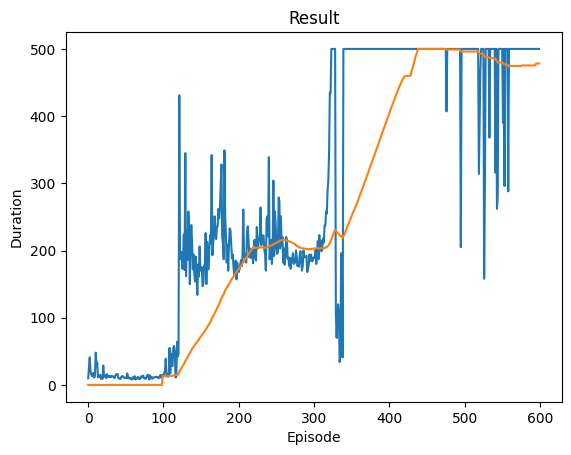

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
# we train for 600 episodes
num_episodes = 600

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Storing the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        # plot the updated graph with this new episode if it is completed
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

# Save the trained model parameters
torch.save(policy_net.state_dict(), 'trained_model.pth')
print("Model saved.")

# plotting the entire graph for the duration of each training episode
print("Training done.")
plot_durations(show_result=True)
plt.ioff()
plt.show()

### Demonstrate correctness

We show the observation and chosen action for our RL DQN agent here:

In [13]:
observation = env.reset()
observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
action = select_action(observation)
print("Observation:", observation.numpy()[0])
print("Chosen action:", action.item())

Observation: [0.04550311 0.00032106 0.04560099 0.03476587]
Chosen action: 1


We see that for this observation, the chosen action is correct

# Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

## 1.   Using Q-Learning



**This code segment is used to evaluate the performance of the trained Q-learning agent over a set number of testing episodes and determine if it can successfully balance the pole on the cart for a significant duration**.

**1)** We define the number of episodes for testing, the maximum number of actions allowed per episode, and initialize variables to store episode results.


> TEST_EPISODES = 100

> MAX_ACTIONS = 500

> prior_reward = 0

> episode_results = np.zeros((TEST_EPISODES + 1,), dtype=int)

> episode_rewards = 0

**2)** The loop runs the testing episodes. It resets the environment for each episode, selects actions based on the Q-policy, and updates the Q-values. Additionally, it decays the epsilon value over time similar to the training phase. Episode rewards are recorded for evaluation.



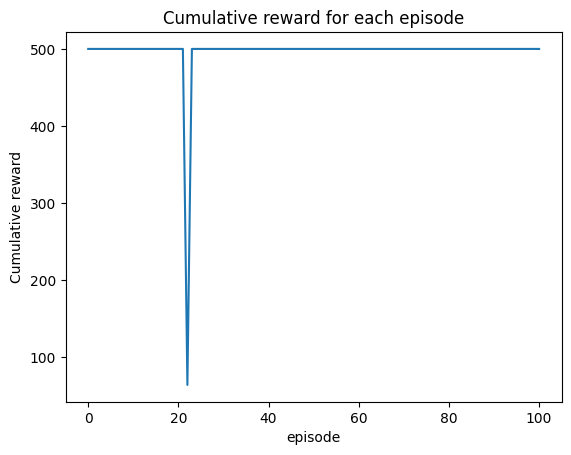

Average cumulative reward: 495.6831683168317
Is my agent good enough? True


In [ ]:
TEST_EPISODES = 100
MAX_ACTIONS = 500
prior_reward = 0
episode_results = np.zeros((TEST_EPISODES + 1,), dtype=int)
episode_rewards = 0

for episode in range(len(episode_results)):
  discrete_state = get_discrete_state(env.reset())
  done = False
  episode_rewards=0
  while not done:
    action = q_policy_agent(q_table,discrete_state,env,epsilon)
    new_state, reward, done, info = env.step(action)
    episode_rewards += reward
    new_discrete_state = get_discrete_state(new_state)

    if not done:
        max_future_q = np.max(q_table[new_discrete_state])
        current_q = q_table[discrete_state + (action,)]
        new_q = (1 - LEARNINGRATE) * current_q + LEARNINGRATE* (reward + DISCOUNT * max_future_q)
        q_table[discrete_state + (action,)] = new_q

    discrete_state = new_discrete_state

  if epsilon > 0.05:
    if episode_rewards > prior_reward and episode > 10000:
      epsilon = math.pow(epsilon_decay_value, episode - 10000)
      lr = math.pow(lr_decay_value, episode - 10000)

  episode_results[episode] = episode_rewards
  prior_reward = episode_rewards


plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

**Print the average reward over the 100 episodes.**

## 2. Q-Learning (Learning Rate: 0.65)

In [ ]:
#Define empty list to store the total rewards obtained in each episode
final_rewardArr = []

#Running 100 episodes
for episodes in range (100):

    #Reset the env and obtain the initial observation
    discrete_state = get_discrete_state(env.reset()[0])
    done = False
    episode_reward = 0

    #Run episodes until done flag is set to True
    while not done:

        #Using Q-table to always choose the best action for current state
        action = np.argmax(q_table[discrete_state])

        #take chosen action in env and obtain new state, reward, and done flag
        new_env = env.step(action)
        new_state = new_env[0]
        reward = new_env[1]
        done = new_env[2]

        #Add reward for the current step to the episode reward variable
        episode_reward += reward

        #Ending the episode also if it reached 500
        if episode_reward >500:
            done = True

        #Convert new state to its discrete equivalent and update discrete_state
        new_discrete_state = get_discrete_state(new_state)
        discrete_state = new_discrete_state

        #if episode is complete, reset env and obtain initial observation and discrete state
        if done:
            observation = env.reset()
            discrete_state = get_discrete_state(observation[0])

    #Append the episode reward to the final_rewardArr list
    final_rewardArr.append(episode_reward)

env.close()

Average cumulative reward:500.0
Is my agent good enough? True


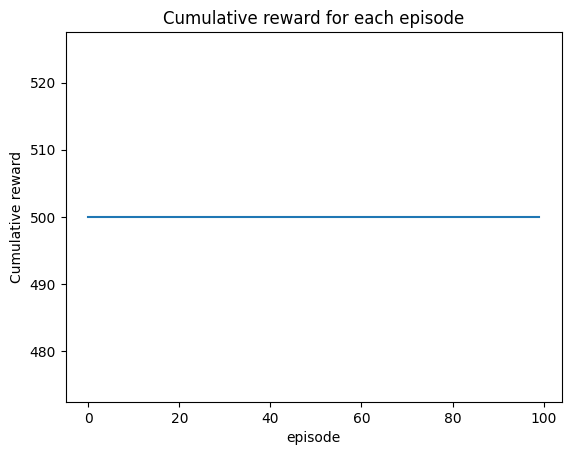

In [ ]:
plt.plot(final_rewardArr)


print("Average cumulative reward:" + str(np.mean(final_rewardArr)))
print("Is my agent good enough? " + str(np.mean(final_rewardArr) > 195))

plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')

plt.show()

## 3. DQN

Below we put to test our trained model by recording the rewards for each of the 100 episodes that we run. We then plot the graph for the episode results.

We first put our policy to evaluation mode, which is used during inference or testing, rather than training. When a model is in evaluation mode, certain operations like dropout and batch normalization are disabled or modified to behave differently than during training. This ensures consistent behavior during inference, as these operations are typically used for regularization and may introduce randomness or variability during training. This allows us to see the effectiveness of our trained agent

In [14]:
# Set the model to evaluation mode
policy_net.eval()

# List to store the durations of each episode
episode_rewards = []

# Testing loop for 100 episodes
for i_episode in range(100):

    # Initialize the environment and get its state
    observation = env.reset()
    observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0

    while True:
        # Select an action using the trained policy network
        action = select_action(observation)

        # Take a step in the environment based on the selected action
        observation, reward, terminated, truncated = env.step(action.item())

        # Update the observation tensor
        observation = torch.tensor(observation, dtype=torch.float32, device=device)

        # Accumulate the reward obtained from the action
        total_reward += reward

        # Check if the episode is done (either terminated or truncated)
        done = terminated or truncated

        # appending the episode to the list
        if done:
            episode_rewards.append(t + 1)
            break

        # Move to the next state
        observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

<ipython-input-14-a5b5961f8e3f>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


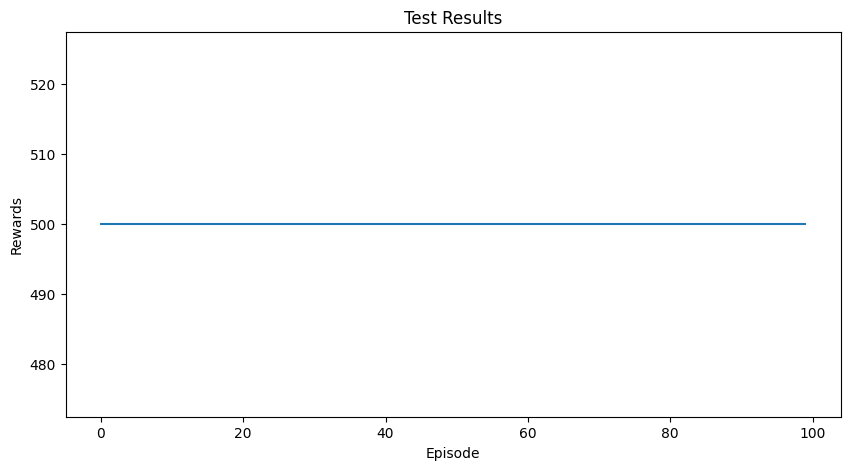

In [15]:
# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards)
plt.title('Test Results')
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.show()

In [16]:
# Printing average cumulative reward and checking if the agent is good enough
average_reward = sum(episode_rewards) / len(episode_rewards)
is_good_enough = average_reward > 195
print("Average cumulative reward:", average_reward)
print("Is my agent good enough?", is_good_enough)

Average cumulative reward: 500.0
Is my agent good enough? True


# Task 3: Render one episode played by the agent

## 3. DQN

In [17]:
# Set the model to evaluation mode
policy_net.eval()

# Initialize the environment and start recording a video
env = RecordVideo(gym.make("CartPole-v1"), "./video")

# Initialize the environment and get its state
observation = env.reset()
observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

# Initialize the total reward to track the cumulative reward obtained during the episode
total_reward = 0

while True:
    # Render the environment
    env.render()

    # Select an action using the trained policy network
    action = select_action(observation)

    # Take a step in the environment based on the selected action
    observation, reward, terminated, truncated = env.step(action.item())

    # Update the observation tensor
    observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    # Accumulate the reward obtained from the action
    total_reward += reward

    # Check if the episode is done (either terminated or truncated)
    done = terminated or truncated
    if done:
      break;

# Print the total reward obtained during the episode
print("Reward: ", total_reward)

# Close the environment and stop recording the video
env.close()

# Display the recorded video
show_video()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Reward:  500.0


# References:
1. The development of the code of the agent Q-Learning (Learning Rate: 0.65) is based on: https://medium.com/swlh/using-q-learning-for-openais-cartpole-v1-4a216ef237df

2. The development of the code of the agent DQN
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

3. SC3000 Reinforcement Learning on Q Learning by Professor Zhang Hanwang